In [1]:
#import required libraries

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [2]:
#Description
#Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples.
# Each example is a 28x28 grayscale image, associated with a label from 10 classes.
#'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'

In [3]:
# Load Fashion MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#create a list of labels
classes=[]
for i in train_labels:
  if i not in classes:
    classes.append(i)

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


4422102/4422102 [==============================] - 0s 0us/step


In [4]:
print(classes)

[9, 0, 3, 2, 7, 5, 1, 6, 4, 8]


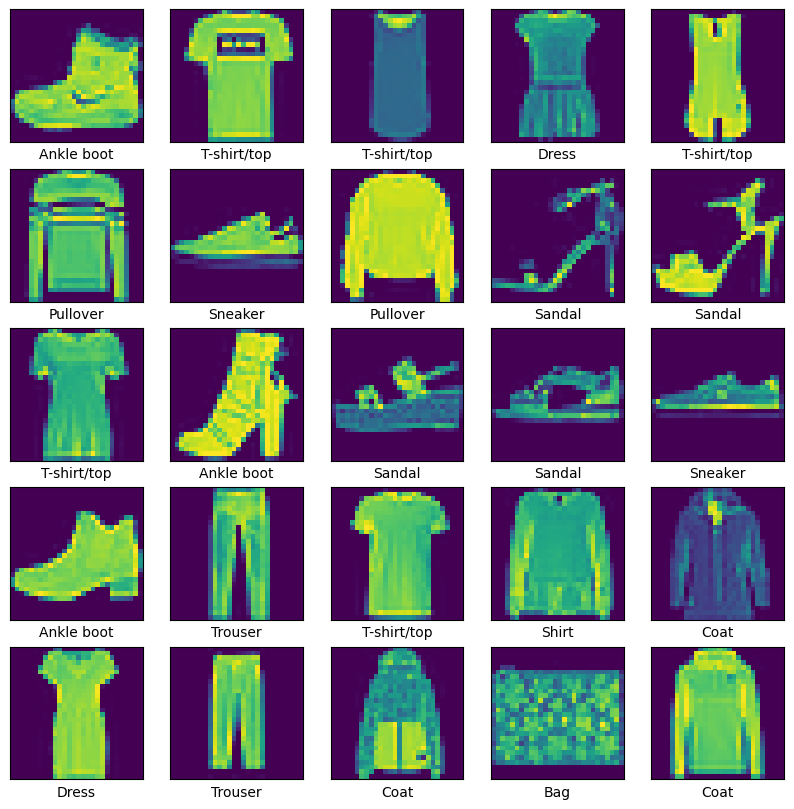

In [5]:
# Display sample images from the dataset
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

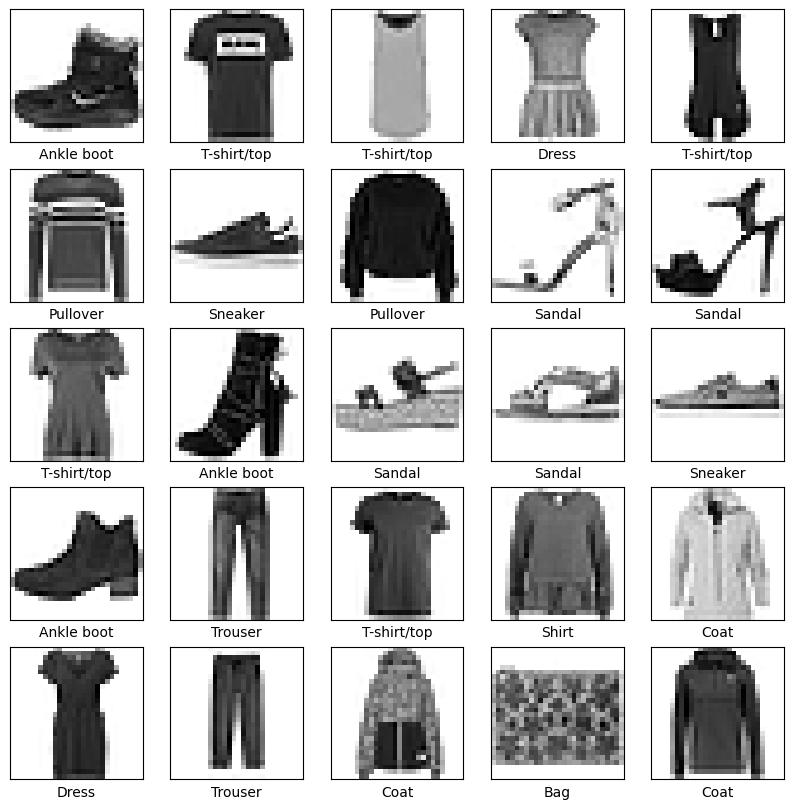

In [6]:
# Display sample images from the dataset
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


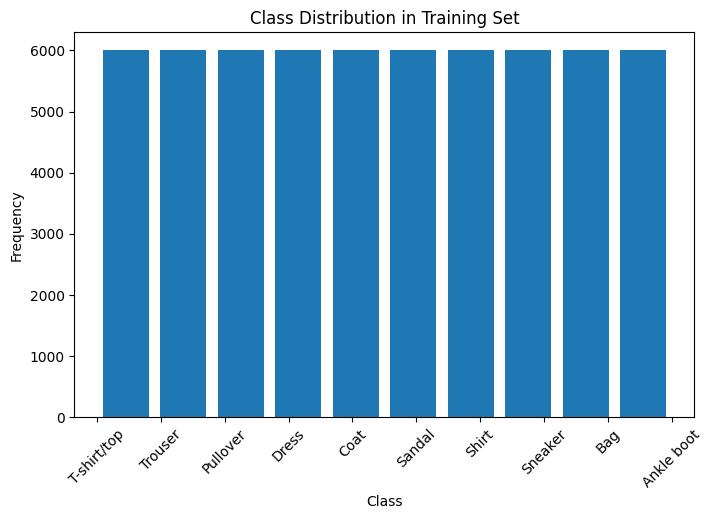

In [7]:
# Plot histogram for class distribution
plt.figure(figsize=(8,5))
plt.hist(train_labels, bins=len(classes), rwidth=0.8)
plt.xticks(range(len(classes)), class_names, rotation=45)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

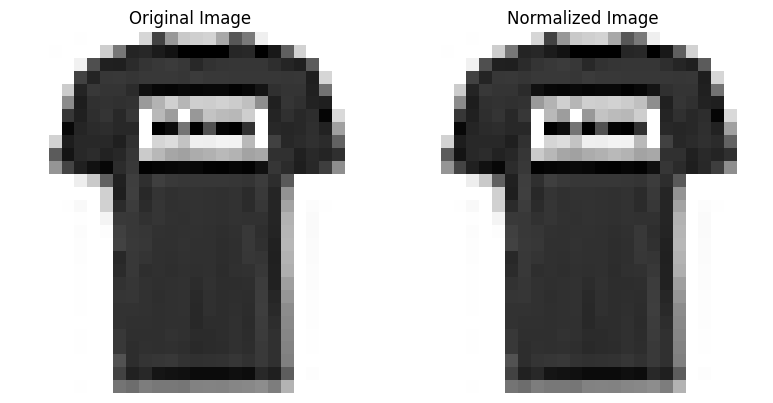

In [8]:
# normalized images
normalized_image = train_images[1] / 255.0  # Normalize pixel values to [0, 1]
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(train_images[1], cmap=plt.cm.binary)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(normalized_image, cmap=plt.cm.binary)
plt.title('Normalized Image')
plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
#Preprocessing by normalizing and resizing images to fit resnet

train_images = np.array([np.pad(image, pad_width=2, mode='constant', constant_values=0) for image in train_images]) / 255.0
test_images = np.array([np.pad(image, pad_width=2, mode='constant', constant_values=0) for image in test_images]) / 255.0
train_images = np.stack((train_images,)*3, axis=-1)  # Convert to 3 channels
test_images = np.stack((test_images,)*3, axis=-1)

# Resize images to 32x32
train_images = tf.image.resize(train_images, [32,32])
test_images = tf.image.resize(test_images, [32,32])

#Training using Transfer Learning - ResNet

In [10]:
#Adapting ResNet to fit the data

def resnet_block(input, filters, kernel_size=3, stride=1):
  x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_initializer='he_normal')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [11]:
# Input layer
inputs = Input(shape=(32, 32, 3))

# Building the ResNet model
x = resnet_block(inputs, 32)  # First block
x = MaxPooling2D(pool_size=2)(x)
x = resnet_block(x, 64, stride=2)
x = resnet_block(x, 128, stride=2)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

# Create the model
model1_resnet = Model(inputs, outputs)

# Model summary
model1_resnet.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496 

In [12]:
model1_resnet.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on original dataset without any augmentation of images
history1_resnet = model1_resnet.fit(train_images, train_labels, epochs=20, batch_size=64, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/20
750/750 [==============================] - 11s 7ms/step - loss: 0.5095 - accuracy: 0.8253 - val_loss: 0.3960 - val_accuracy: 0.8591
Epoch 2/20
750/750 [==============================] - 4s 6ms/step - loss: 0.3122 - accuracy: 0.8882 - val_loss: 0.3479 - val_accuracy: 0.8776
Epoch 3/20
750/750 [==============================] - 4s 6ms/step - loss: 0.2699 - accuracy: 0.9031 - val_loss: 0.3399 - val_accuracy: 0.8745
Epoch 4/20
750/750 [==============================] - 5s 7ms/step - loss: 0.2425 - accuracy: 0.9122 - val_loss: 0.3037 - val_accuracy: 0.8876
Epoch 5/20
750/750 [==============================] - 4s 6ms/step - loss: 0.2198 - accuracy: 0.9200 - val_loss: 0.3158 - val_accuracy: 0.8894
Epoch 6/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2016 - accuracy: 0.9269 - val_loss: 0.3291 - val_accuracy: 0.8863
Epoch 7/20
750/750 [==============================] - 4s 6ms/step - loss: 0.1849 - accuracy: 0.9335 - val_loss: 0.2843 - val_accuracy: 0.9013
Epoch

In [13]:
test_loss_resnet1, test_acc_resnet1 = model1_resnet.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc_resnet1}')

313/313 [==============================] - 1s 4ms/step - loss: 0.2975 - accuracy: 0.9027
Test accuracy: 0.9027000069618225


313/313 [==============================] - 1s 3ms/step
[[827   3  14  22   1   0 127   0   6   0]
 [  4 979   2  10   2   0   2   0   1   0]
 [ 16   2 890   6  16   0  70   0   0   0]
 [ 14   5  13 901   9   0  57   0   1   0]
 [  2   0 102  43 735   0 117   0   1   0]
 [  0   0   0   0   0 979   0  10   5   6]
 [ 80   0  49  24  28   0 814   0   5   0]
 [  0   0   0   0   0  12   0 952   1  35]
 [  1   1   0   6   0   1   7   3 980   1]
 [  0   0   0   0   1   4   1  24   0 970]]


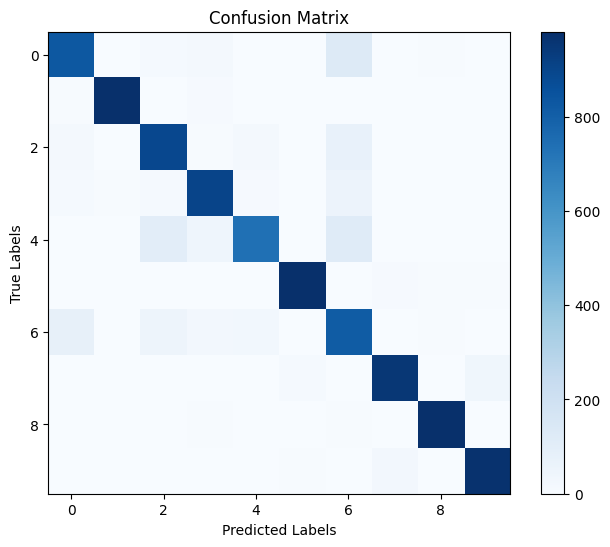

In [14]:
# Predict classes for the test dataset
y_pred1 = np.argmax(model1_resnet.predict(test_images), axis=1)

cm = confusion_matrix(test_labels, y_pred1)
print(cm)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

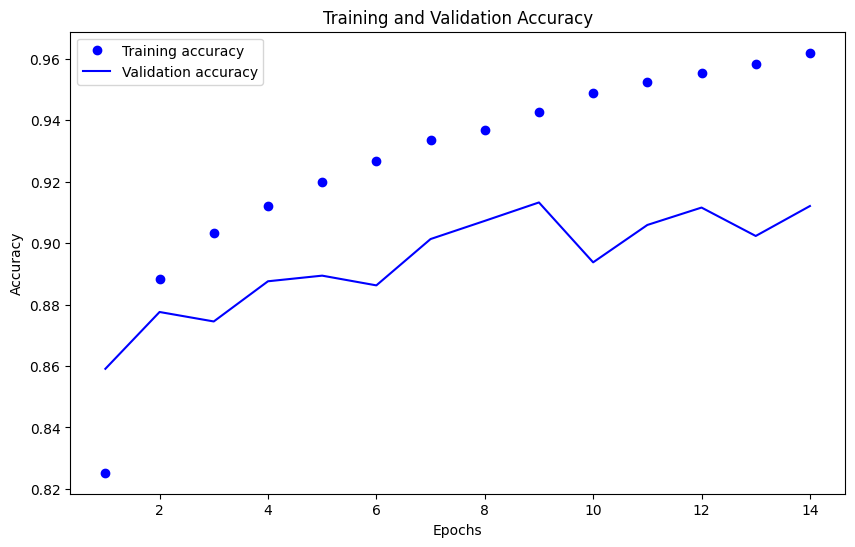

In [15]:
acc = history1_resnet.history['accuracy']
val_acc = history1_resnet.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


#Included l2 Regularizer, used learning rate scheduler


In [16]:
# Define learning rate schedule
def lr_schedule(epoch, initial_lr):
    lr = initial_lr * math.exp(-0.1 * epoch)  # Example: Exponential decay
    return lr

initial_lr = 0.001  # Initial learning rate
optimizer = Adam(learning_rate=initial_lr)

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lambda epoch: lr_schedule(epoch, initial_lr))


# Input layer
inputs = Input(shape=(32, 32, 3))

# Building the ResNet model
x = resnet_block(inputs, 32)  # First block
x = MaxPooling2D(pool_size=2)(x)
x = resnet_block(x, 64, stride=2)
x = resnet_block(x, 128, stride=2)
x = GlobalAveragePooling2D()(x)
x = Dense(128, kernel_regularizer=l2(0.01), activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

# Create the model
model2_resnet = Model(inputs, outputs)

# Model summary
model2_resnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_3 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          1849

In [17]:
model2_resnet.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

for layer in model2_resnet.layers:
  if 'conv2d' in layer.name:
    layer.trainable = True  # Unfreezing Conv2D layers

# Train the model
history2_resnet = model2_resnet.fit(train_images, train_labels, epochs=30, batch_size=64, validation_split=0.2, callbacks=[lr_scheduler,EarlyStopping(monitor='val_loss', patience=5)])

test_loss_resnet2, test_acc_resnet2 = model2_resnet.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc_resnet2}')

Epoch 1/30
750/750 [==============================] - 8s 7ms/step - loss: 0.8454 - accuracy: 0.8131 - val_loss: 0.5850 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 2/30
750/750 [==============================] - 5s 6ms/step - loss: 0.4236 - accuracy: 0.8773 - val_loss: 0.4321 - val_accuracy: 0.8659 - lr: 9.0484e-04
Epoch 3/30
750/750 [==============================] - 5s 6ms/step - loss: 0.3625 - accuracy: 0.8922 - val_loss: 0.4222 - val_accuracy: 0.8689 - lr: 8.1873e-04
Epoch 4/30
750/750 [==============================] - 5s 6ms/step - loss: 0.3297 - accuracy: 0.9020 - val_loss: 0.3471 - val_accuracy: 0.8910 - lr: 7.4082e-04
Epoch 5/30
750/750 [==============================] - 4s 6ms/step - loss: 0.3065 - accuracy: 0.9075 - val_loss: 0.3541 - val_accuracy: 0.8896 - lr: 6.7032e-04
Epoch 6/30
750/750 [==============================] - 5s 7ms/step - loss: 0.2861 - accuracy: 0.9124 - val_loss: 0.3571 - val_accuracy: 0.8857 - lr: 6.0653e-04
Epoch 7/30
750/750 [==============================

313/313 [==============================] - 1s 2ms/step
[[840   0  19  27   5   1  99   0   9   0]
 [  2 979   1  14   3   0   1   0   0   0]
 [ 15   1 862  12  53   0  55   0   2   0]
 [ 13   4  11 911  26   1  30   0   4   0]
 [  1   1  36  23 904   0  34   0   1   0]
 [  1   0   0   0   0 966   1  18   1  13]
 [ 81   1  45  26  72   0 764   0  11   0]
 [  0   0   0   0   0  11   0 959   1  29]
 [  1   0   2   3   2   2   6   3 979   2]
 [  0   0   0   0   1   3   0  32   0 964]]


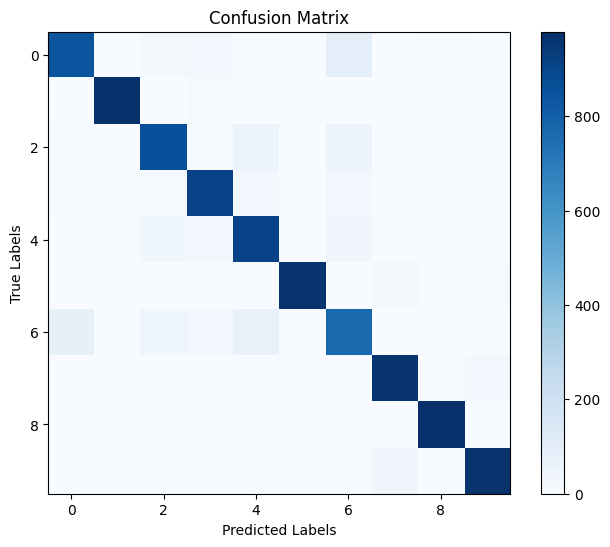

In [18]:
# Predict classes for the test dataset
y_pred2 = np.argmax(model2_resnet.predict(test_images), axis=1)

cm = confusion_matrix(test_labels, y_pred2)
print(cm)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

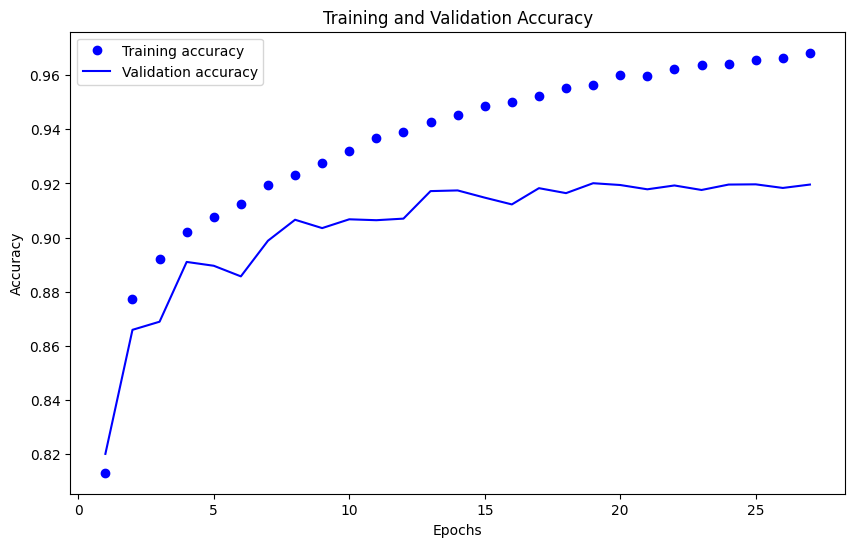

In [19]:
acc = history2_resnet.history['accuracy']
val_acc = history2_resnet.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
train_images.shape

TensorShape([60000, 32, 32, 3])

#Training ResNet by defreezing a layer and using augmented data

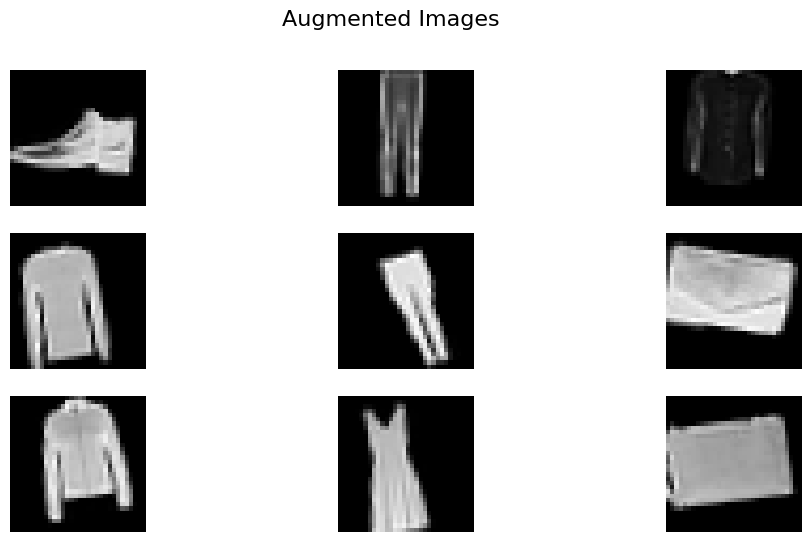

In [21]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # rotate images to 20 degrees
    width_shift_range=0.1,  # shift images horizontally
    height_shift_range=0.1,  # shift images vertically
    zoom_range=0.1,  #  zoom image
    horizontal_flip=True,  # flip images horizontally
    vertical_flip=False,  # do not flip images vertically
    fill_mode='nearest'  # strategy for filling in newly created pixels after rotation or shifting
)

# Fit the ImageDataGenerator on the training data
datagen.fit(train_images)

# Visualize a few augmented images
augmented_images = datagen.flow(train_images, batch_size=1)
plt.figure(figsize=(12, 6))
for i in range(9):
    augmented_image = augmented_images.next()[0].squeeze()
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image, cmap=plt.cm.binary)
    plt.axis('off')
plt.suptitle('Augmented Images', fontsize=16)
plt.show()


In [22]:
# generate augmented images
batch_size = 32
augmented_data_generator = datagen.flow(train_images, train_labels, batch_size=batch_size)

# Concatenate original and augmented data
augmented_train_images = []
augmented_train_labels = []

# Append original data
augmented_train_images.append(train_images)
augmented_train_labels.append(train_labels)

batches = 0
for x_batch, y_batch in augmented_data_generator:
    augmented_train_images.append(x_batch)
    augmented_train_labels.append(y_batch)
    batches += 1
    if batches >= len(train_images) / batch_size:
        # Generator loops indefinitely, break after one pass through the data
        break

augmented_train_images = np.vstack(augmented_train_images)
augmented_train_labels = np.hstack(augmented_train_labels)

# Check the shape of augmented data
print('Augmented train images shape:', augmented_train_images.shape)
print('Augmented train labels shape:', augmented_train_labels.shape)

Augmented train images shape: (120000, 32, 32, 3)
Augmented train labels shape: (120000,)


In [23]:
# Define learning rate schedule
def lr_schedule(epoch, initial_lr):
    lr = initial_lr * math.exp(-0.1 * epoch)  # Example: Exponential decay
    return lr

initial_lr = 0.001  # Initial learning rate
optimizer = Adam(learning_rate=initial_lr)

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lambda epoch: lr_schedule(epoch, initial_lr))


# Input layer
inputs = Input(shape=(32, 32, 3))

# Building the ResNet model
x = resnet_block(inputs, 32)  # First block
x = MaxPooling2D(pool_size=2)(x)
x = resnet_block(x, 64, stride=1)
x = resnet_block(x, 128, stride=2)
x = GlobalAveragePooling2D()(x)
x = Dense(128, kernel_regularizer=l2(0.01), activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

# Create the model
model3_resnet = Model(inputs, outputs)

# Model summary
model3_resnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        1849

In [24]:
model3_resnet.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

for layer in model3_resnet.layers:
  if 'conv2d' in layer.name:
    layer.trainable = True  # Unfreezing Conv2D layers

# Train the model
history3_resnet = model3_resnet.fit(augmented_train_images, augmented_train_labels, epochs=30, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler])

test_loss_resnet3, test_acc_resnet3 = model3_resnet.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc_resnet3}')

Epoch 1/30
3000/3000 [==============================] - 23s 6ms/step - loss: 0.8244 - accuracy: 0.7619 - val_loss: 0.9803 - val_accuracy: 0.6628 - lr: 0.0010
Epoch 2/30
3000/3000 [==============================] - 17s 6ms/step - loss: 0.5491 - accuracy: 0.8264 - val_loss: 1.0132 - val_accuracy: 0.6542 - lr: 9.0484e-04
Epoch 3/30
3000/3000 [==============================] - 17s 6ms/step - loss: 0.4895 - accuracy: 0.8435 - val_loss: 0.7958 - val_accuracy: 0.7380 - lr: 8.1873e-04
Epoch 4/30
3000/3000 [==============================] - 17s 6ms/step - loss: 0.4507 - accuracy: 0.8554 - val_loss: 0.6834 - val_accuracy: 0.7609 - lr: 7.4082e-04
Epoch 5/30
3000/3000 [==============================] - 17s 6ms/step - loss: 0.4191 - accuracy: 0.8651 - val_loss: 0.5517 - val_accuracy: 0.8149 - lr: 6.7032e-04
Epoch 6/30
3000/3000 [==============================] - 18s 6ms/step - loss: 0.4002 - accuracy: 0.8716 - val_loss: 0.7322 - val_accuracy: 0.7635 - lr: 6.0653e-04
Epoch 7/30
3000/3000 [==========

313/313 [==============================] - 1s 2ms/step
[[825   0  20  33   2   0 114   0   6   0]
 [  0 978   3  16   0   0   2   0   1   0]
 [ 16   0 900   4  44   0  36   0   0   0]
 [  5   4  13 916  26   0  36   0   0   0]
 [  0   0  46  27 876   0  49   0   2   0]
 [  0   0   0   0   0 971   1  18   0  10]
 [ 73   2  57  28  65   0 772   0   3   0]
 [  0   0   0   0   0   7   0 946   0  47]
 [  1   2   4   2   1   3   4   1 982   0]
 [  0   0   0   1   0   5   0  20   0 974]]


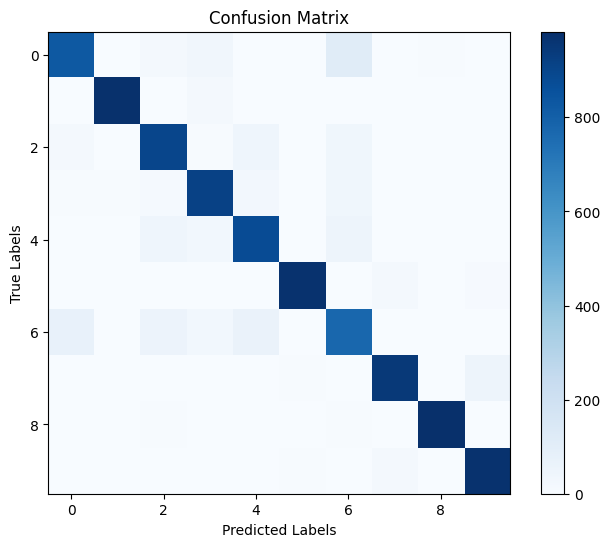

In [25]:
# Predict classes for the test dataset
y_pred3 = np.argmax(model3_resnet.predict(test_images), axis=1)

cm = confusion_matrix(test_labels, y_pred3)
print(cm)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

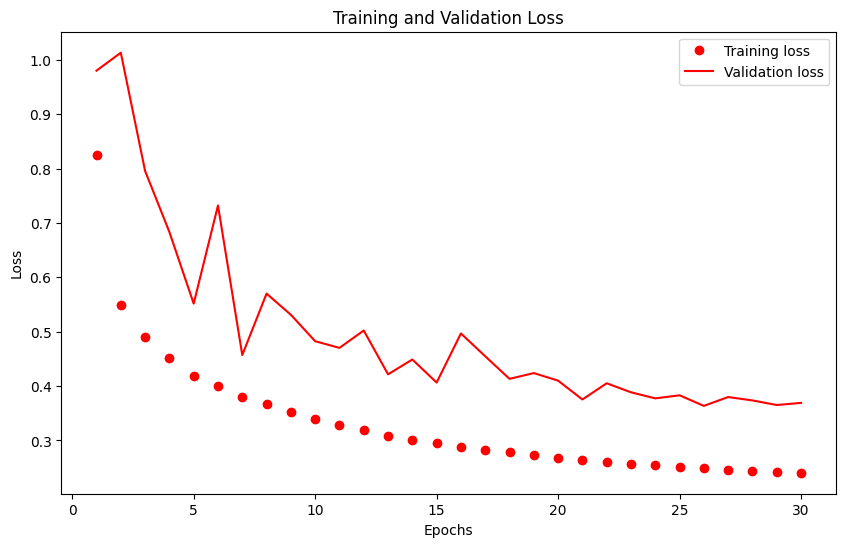

In [26]:
loss = history3_resnet.history['loss']
val_loss = history3_resnet.history['val_loss']
epochs = range(1, len(loss) + 1)


# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

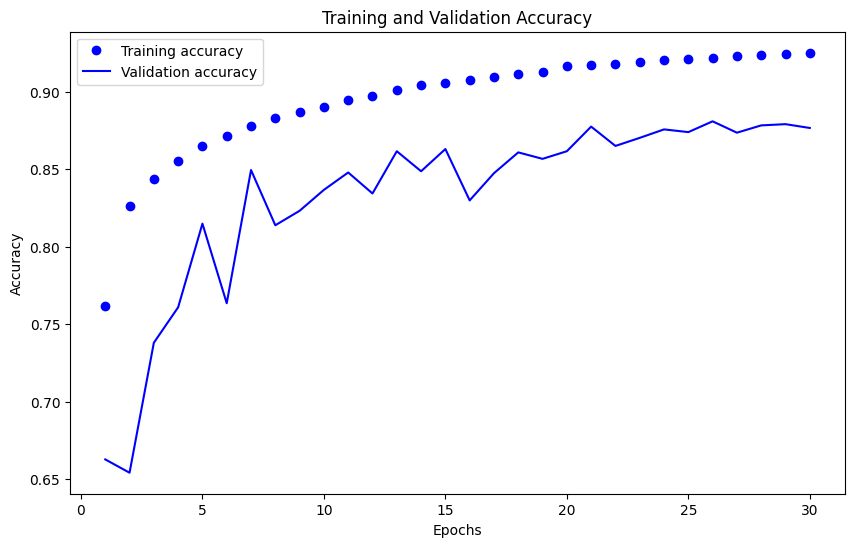

In [27]:
acc = history3_resnet.history['accuracy']
val_acc = history3_resnet.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


#Fine Tuning Initial Model by adding dropouts

In [28]:
# Load Fashion MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#create a list of labels
classes=[]
for i in train_labels:
  if i not in classes:
    classes.append(i)

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [29]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

In [30]:
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

In [31]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # rotate images to 20 degrees
    width_shift_range=0.1,  # shift images horizontally
    height_shift_range=0.1,  # shift images vertically
    zoom_range=0.1,  #  zoom image
    horizontal_flip=True,  # flip images horizontally
    vertical_flip=False,  # do not flip images vertically
    fill_mode='nearest'  # strategy for filling in newly created pixels after rotation or shifting
)

# Fit the ImageDataGenerator on the training data
datagen.fit(train_images_norm)


In [32]:
# generate augmented images
batch_size = 32
augmented_data_generator = datagen.flow(train_images_norm, train_labels, batch_size=batch_size)

# Concatenate original and augmented data
augmented_train_images = []
augmented_train_labels = []

# Append original data
augmented_train_images.append(train_images)
augmented_train_labels.append(train_labels)

batches = 0
for x_batch, y_batch in augmented_data_generator:
    augmented_train_images.append(x_batch)
    augmented_train_labels.append(y_batch)
    batches += 1
    if batches >= len(train_images) / batch_size:
        # Generator loops indefinitely, break after one pass through the data
        break

augmented_train_images = np.vstack(augmented_train_images)
augmented_train_labels = np.hstack(augmented_train_labels)

# Check the shape of augmented data
print('Augmented train images shape:', augmented_train_images.shape)
print('Augmented train labels shape:', augmented_train_labels.shape)

Augmented train images shape: (120000, 28, 28, 1)
Augmented train labels shape: (120000,)


In [33]:
# Define the model architecture
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 output classes
])

# Compile the model
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                   

In [37]:
history1=model1.fit(augmented_train_images, augmented_train_labels, epochs=30, batch_size=64, shuffle=True, validation_split=0.1)

Epoch 1/30
1688/1688 [==============================] - 13s 7ms/step - loss: 0.4297 - accuracy: 0.8397 - val_loss: 0.4557 - val_accuracy: 0.8254
Epoch 2/30
1688/1688 [==============================] - 12s 7ms/step - loss: 0.3867 - accuracy: 0.8568 - val_loss: 0.4344 - val_accuracy: 0.8329
Epoch 3/30
1688/1688 [==============================] - 11s 7ms/step - loss: 0.3766 - accuracy: 0.8589 - val_loss: 0.4163 - val_accuracy: 0.8444
Epoch 4/30
1688/1688 [==============================] - 12s 7ms/step - loss: 0.3660 - accuracy: 0.8643 - val_loss: 0.4477 - val_accuracy: 0.8269
Epoch 5/30
1688/1688 [==============================] - 11s 7ms/step - loss: 0.3617 - accuracy: 0.8648 - val_loss: 0.4243 - val_accuracy: 0.8402
Epoch 6/30
1688/1688 [==============================] - 11s 7ms/step - loss: 0.3552 - accuracy: 0.8668 - val_loss: 0.4050 - val_accuracy: 0.8493
Epoch 7/30
1688/1688 [==============================] - 11s 7ms/step - loss: 0.3492 - accuracy: 0.8675 - val_loss: 0.4175 - val_ac

In [40]:
from keras.models import load_model
model1=load_model("/content/sample_data/model1.keras")

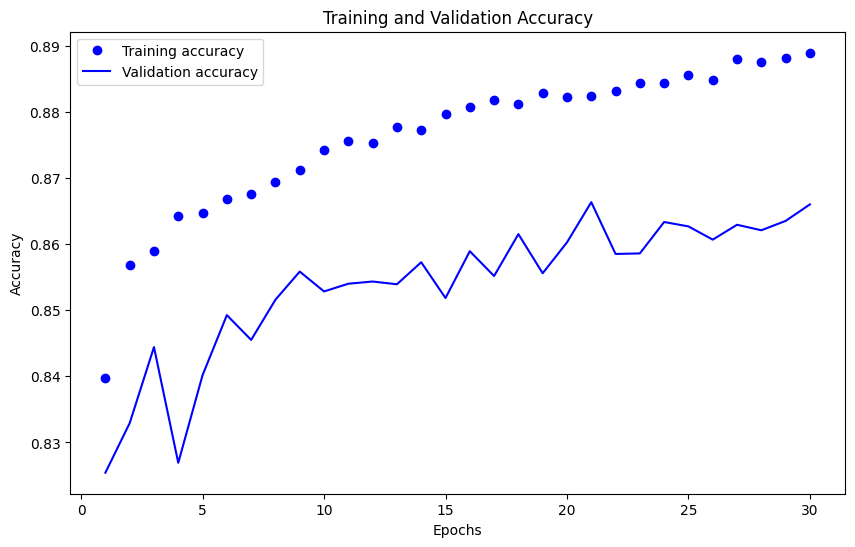

In [41]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [42]:
# Predict classes for the test dataset
y_pred4 = np.argmax(model1.predict(test_images), axis=1)
# Evaluate the model on 1est data
test_loss1, test_accuracy1 = model1.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy1 * 100:.2f}%')

313/313 [==============================] - 1s 3ms/step - loss: 0.2072 - accuracy: 0.9237
Test accuracy: 92.37%


[[898   0  15   6   3   1  72   0   5   0]
 [  3 982   0  10   1   0   3   0   1   0]
 [ 16   0 865   6  65   0  48   0   0   0]
 [ 12   1   8 923  30   1  24   0   1   0]
 [  0   0  15  18 913   0  54   0   0   0]
 [  0   0   0   0   0 982   0  13   0   5]
 [105   0  56  23  66   0 744   0   6   0]
 [  0   0   0   0   0   6   0 981   0  13]
 [  2   0   2   4   1   1   3   0 987   0]
 [  0   0   0   0   0   7   0  31   0 962]]


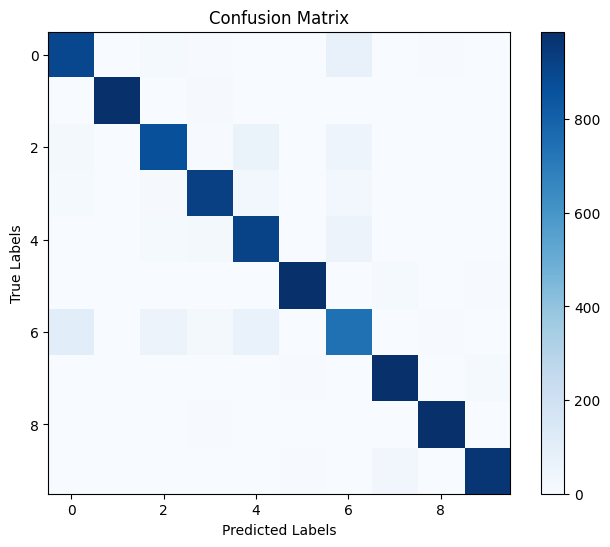

In [43]:
cm = confusion_matrix(test_labels, y_pred4)
print(cm)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##with learning rate scheduler

In [ ]:
history2=model1.fit(augmented_train_images, augmented_train_labels, epochs=25, validation_split=0.2, callbacks=[lr_scheduler])

Epoch 1/25
3000/3000 [==============================] - 17s 6ms/step - loss: 0.4179 - accuracy: 0.8454 - val_loss: 0.4353 - val_accuracy: 0.8312 - lr: 0.0010
Epoch 2/25
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3625 - accuracy: 0.8654 - val_loss: 0.4064 - val_accuracy: 0.8547 - lr: 9.0484e-04
Epoch 3/25
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3420 - accuracy: 0.8717 - val_loss: 0.3968 - val_accuracy: 0.8491 - lr: 8.1873e-04
Epoch 4/25
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3312 - accuracy: 0.8755 - val_loss: 0.3997 - val_accuracy: 0.8478 - lr: 7.4082e-04
Epoch 5/25
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3177 - accuracy: 0.8815 - val_loss: 0.4486 - val_accuracy: 0.8223 - lr: 6.7032e-04
Epoch 6/25
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3066 - accuracy: 0.8843 - val_loss: 0.3809 - val_accuracy: 0.8552 - lr: 6.0653e-04
Epoch 7/25
3000/3000 [==========

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Predict classes for the test dataset
y_pred5 = np.argmax(model1.predict(test_images), axis=1)
# Evaluate the model on test data
test_loss2, test_accuracy2 = model1.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy2 * 100:.2f}%')

313/313 [==============================] - 1s 3ms/step - loss: 0.2052 - accuracy: 0.9269
Test accuracy: 92.69%


[[863   0  14  12   2   1 101   0   7   0]
 [  2 984   0   9   0   0   3   0   2   0]
 [ 11   0 910  10  32   0  36   0   1   0]
 [  8   2   8 945  13   0  23   0   1   0]
 [  1   1  51  23 866   0  57   0   1   0]
 [  0   0   0   0   0 985   0  10   0   5]
 [ 83   0  62  19  46   0 782   0   8   0]
 [  0   0   0   0   0   6   0 982   0  12]
 [  1   0   1   5   0   2   1   0 990   0]
 [  0   0   0   0   0   5   0  33   0 962]]


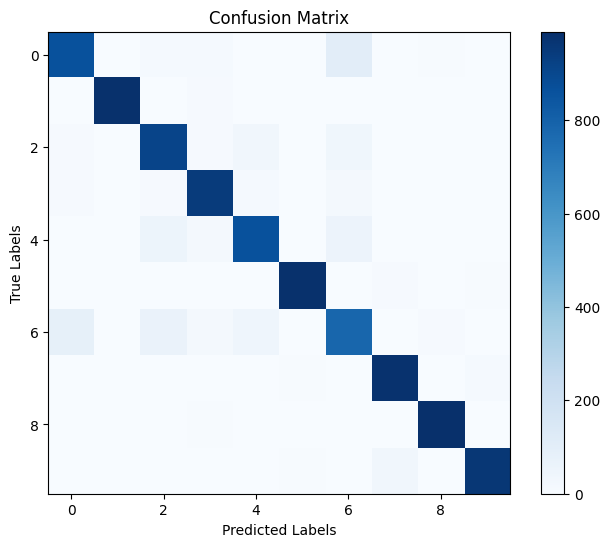

In [ ]:
cm = confusion_matrix(test_labels, y_pred5)
print(cm)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
misclassified_idx = np.where(test_labels != y_pred5)[0]
print("Misclassified Examples:",len(misclassified_idx))

Misclassified Examples: 731


#Initial model

In [53]:
model = models.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(10, activation='softmax')  # 10 output classes
  ])

model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Display the model summary
model.summary()
history=model.fit(augmented_train_images, augmented_train_labels, epochs=25, validation_split=0.2, callbacks=[lr_scheduler])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 576)              

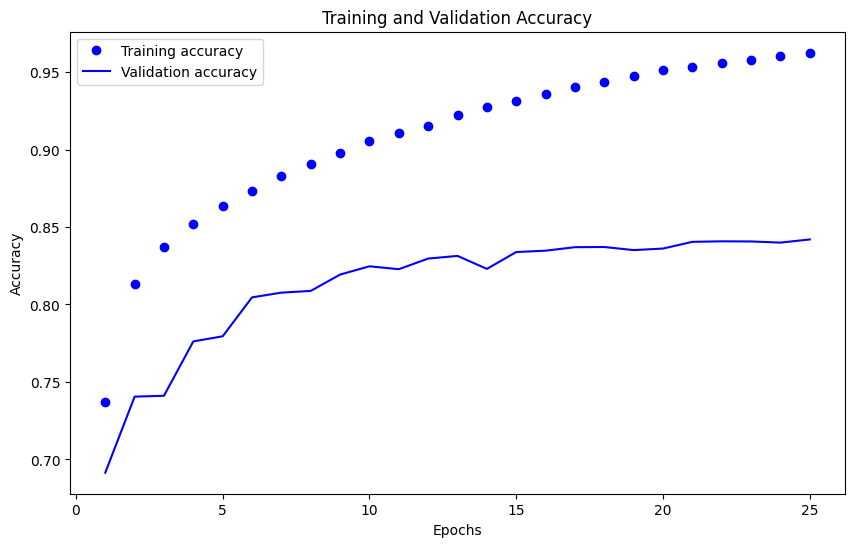

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [55]:
# Predict classes for the test dataset
y_pred = np.argmax(model.predict(test_images), axis=1)

313/313 [==============================] - 1s 3ms/step


In [56]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


313/313 [==============================] - 1s 3ms/step - loss: 0.2072 - accuracy: 0.9237
Test accuracy: 92.37%


[[839   1  21  24   4   0 103   0   7   1]
 [  3 979   0  15   1   0   0   0   2   0]
 [ 20   1 850   9  58   0  60   0   2   0]
 [ 14   1  11 919  20   0  30   0   5   0]
 [  0   0  52  29 869   0  49   0   1   0]
 [  0   0   0   0   0 981   0  14   0   5]
 [111   0  69  29  83   0 698   0  10   0]
 [  0   0   0   0   0  12   0 968   0  20]
 [  4   0   2   5   4   4   9   2 969   1]
 [  0   0   0   0   0   6   0  34   0 960]]


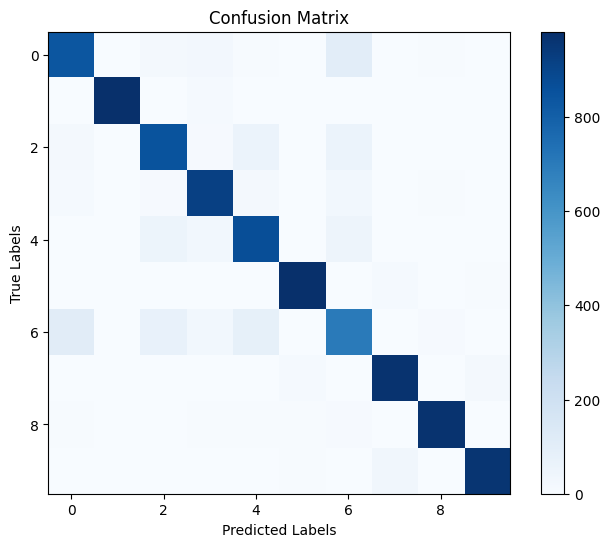

In [57]:
# Confusion Matrix

cm = confusion_matrix(test_labels, y_pred)
print(cm)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [58]:
# Display misclassified examples
misclassified_idx = np.where(test_labels != y_pred)[0]
print("Misclassified Examples:",len(misclassified_idx))

Misclassified Examples: 968


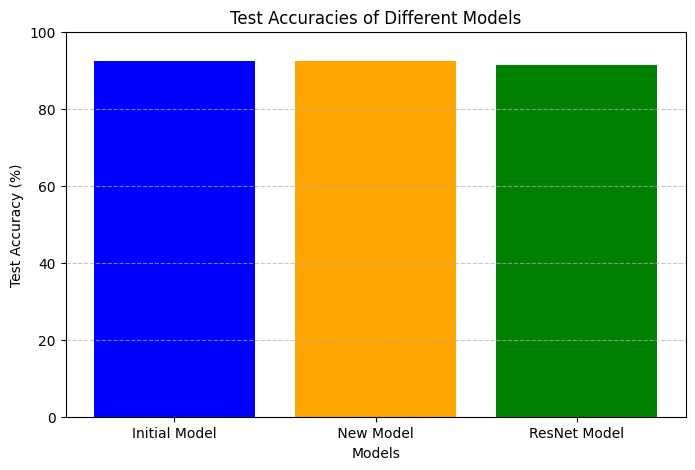

In [61]:
import matplotlib.pyplot as plt

# Test accuracies
accuracies = [test_accuracy * 100, test_accuracy1 * 100, test_acc_resnet3*100]
models = ['Initial Model', ' New Model ', 'ResNet Model']

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracies of Different Models')
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()